In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
import scipy.stats as stats

C:\Users\hari_surender_sharma\AppData\Local\conda\conda\envs\python3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#data = pd.read_csv('Train_SU63ISt.csv')
#data = data.drop(columns=['ID'])
#data['Datetime'] = pd.to_datetime(data['Datetime'])
#data.to_csv('train_data.csv',index=False)

In [3]:
data = pd.read_csv('train_data.csv')
data['Datetime'] = pd.to_datetime(data['Datetime'])
data.head()

,Datetime,Count
0,2012-08-25 00:00:00,8
1,2012-08-25 01:00:00,2
2,2012-08-25 02:00:00,6
3,2012-08-25 03:00:00,2
4,2012-08-25 04:00:00,2


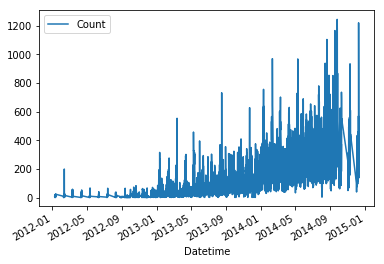

In [4]:
data.plot(x='Datetime',y='Count')

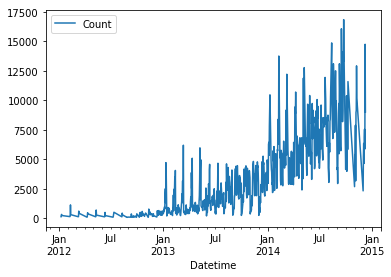

In [5]:
per = data['Datetime'].dt.to_period('D')
data_month = data.groupby(per).sum()
data_month.plot()

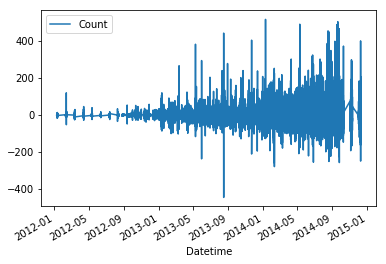

In [6]:
data_diff_1 = data.set_index('Datetime').diff()
data_diff_1 = data_diff_1.reset_index()
data_diff_1.plot(x='Datetime',y='Count')

Text(0.5,1,'Time Series')

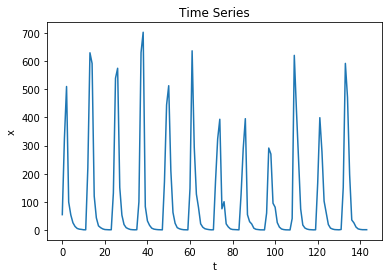

In [7]:
#ex = pd.read_csv('examples2.csv')
#ex = data_diff_1
ex = pd.read_csv('examples3.csv')
x = ex.values#[1:,:]
plt.plot(x[:,1])
plt.xlabel('t')
plt.ylabel('x')
plt.title('Time Series')

In [8]:
def build_correlogram(x,k=10):
    r = np.zeros((k+1))
    x_t = x[:,1]
    #print('x_t',x_t)
    n = x.shape[0]
    x_bar = np.mean(x_t,axis=0)
    #print('x_bar',x_bar)
    c0 = (1/(n-1))*np.sum(np.square(x_t-x_bar),axis=0)
    #print('c0',c0)
    x_t_trunc = x_t
    x_t_plus_k = x_t
    for i in range(0,k+1):
        #print('i',i)
        c_k = ((1/n)*np.sum(((x_t_trunc-x_bar)*(x_t_plus_k-x_bar)),axis=0))
        #print('c_k',c_k)
        r[i]= c_k/c0
        #print('x_t_trunc',x_t_trunc)
        #print('x_t_plus_k',x_t_plus_k)
        x_t_trunc = x_t_trunc[0:-1]
        x_t_plus_k = x_t[i+1:]
    return r   

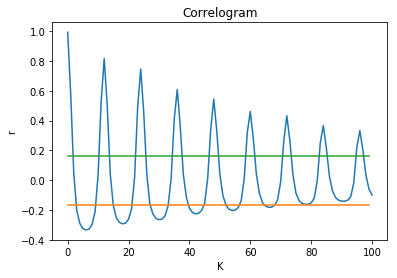

In [9]:
k = 100
r = build_correlogram(x,k)
np.set_printoptions(precision=4)
#print(r)
lowerbound=[0-1.96/math.sqrt(x.shape[0])]*k
upperbound = [0+1.96/math.sqrt(x.shape[0])]*k
plt.plot(r)
plt.plot(lowerbound)
plt.plot(upperbound)
plt
plt.xlabel('K')
plt.ylabel('r')
plt.title('Correlogram')
plt.show()

In [10]:
def build_line_spectrum(x,k=10):
    x_t = x[:,1]
    alpha = np.zeros((k))
    beta = np.zeros((k))
    I = np.zeros((k))
    N = x.shape[0]
    w = (2*math.pi*np.arange(1,k+1))/N
    t = np.arange(1,N+1)
    #print(t)
    for i in range(k):
        f_k = (i+1)/N
        cosine = np.cos(2*math.pi*f_k*t)
        alpha[i] = (2/N)*np.sum((np.multiply(x_t,cosine)),axis=0)
        #print('alpha',alpha[i])
        sine = np.sin(2*math.pi*f_k*t)
        beta[i] = (2/N)*np.sum((np.multiply(x_t,sine)),axis=0)
        #print('beta',beta[i])
        I[i] = (N/2)*(np.square(alpha[i])+np.square(beta[i]))
    return w,I

Text(0.5,1,'Line Spectrum')

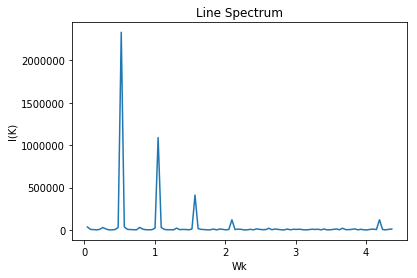

In [11]:
w,I = build_line_spectrum(x,k=100)
#print(w)
plt.plot(w,I)
plt.xlabel('Wk')
plt.ylabel('I(K)')
plt.title('Line Spectrum')

In [12]:
def build_power_spectrum(x,k=10):
    x_t = x[:,1]
    alpha = np.zeros((k))
    beta = np.zeros((k))
    I = np.zeros((k))
    N = x.shape[0]
    w = (2*math.pi*np.arange(1,k+1))/N
    x_bar = np.mean(x_t,axis=0)
    c0 = (1/(N-1))*np.sum(np.square(x_t-x_bar),axis=0)
    if N%2 == 0:
        max_lag = int(N/2)
    else:
        max_lag = int((N-1)/2)
    t = np.arange(1,max_lag+1)
    c_k = np.zeros((max_lag))
    c_k = sts.acovf(x_t,unbiased=False)
    tukey_win = (1/2)*(1+np.cos((2*math.pi*t)/(0.25*N)))
    for i in range(k):
        f_k = (i+1)/N
        I[i] = 2*(c_k[0] + 2*(np.sum((tukey_win*c_k[1:max_lag+1]*np.cos(2*math.pi*f_k*t)),axis=0)))
        
    return w,I

Text(0.5,1,'Power Spectrum')

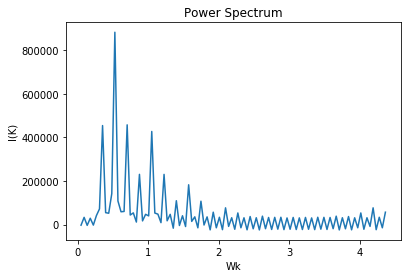

In [13]:
w,I = build_power_spectrum(x,k=100)
plt.plot(w,I)
plt.xlabel('Wk')
plt.ylabel('I(K)')
plt.title('Power Spectrum')

In [14]:
def significance_test(I,w_k,data):
    N = data.shape[0]
    x_t = data[:,1]
    #i = np.argmax(I)+1
    i = (w_k*N)/(2*math.pi)
    #w_k = (2*math.pi*(i+1))/N
    p = 2*math.pi/w_k
    print('w_k',w_k)
    print('periodicity',p)
    x_bar = np.mean(x_t,axis=0)
    #print('x_bar',x_bar)
    t = np.arange(1,N+1)
    f_k = (i)/N
    cosine = np.cos(2*math.pi*f_k*t)
    alpha_hat = (2/N)*np.sum((np.multiply(x_t,cosine)),axis=0)
    #print('alpha_hat',alpha_hat)
    sine = np.sin(2*math.pi*f_k*t)
    beta_hat = (2/N)*np.sum((np.multiply(x_t,sine)),axis=0)
    #print('beta_hat',beta_hat)
    gamma_sqr = np.square(alpha_hat)+np.square(beta_hat)
    #print('gamma_sqr',gamma_sqr)
    #print('np.cos(w_k*t)',np.cos(w_k*t))
    #print('np.sin(w_k*t)',np.sin(w_k*t))
    #print('x_t',x_t)
    ro_hat = (1/N)*(np.sum(np.square(x_t - alpha_hat*np.cos(w_k*t) - beta_hat*np.sin(w_k*t)),axis=0))
    #ro_hat = (1/N)*(np.sum(x_t,axis=0))
    #print('ro_hat',ro_hat)
    test_stat = (gamma_sqr*(N-2))/(4*ro_hat)
    print('test_stat',test_stat)
    print('f(2,N-2)',stats.f.ppf(q=1-0.05,dfn=2,dfd=N-2))
    y_t = x_bar + alpha_hat*np.cos(w_k*t) + beta_hat*np.sin(w_k*t)
    return y_t


In [15]:
i = np.argmax(I)
w_k = (2*math.pi*(i+1))/x.shape[0]
y_t = significance_test(I,w_k,x)

w_k 0.5235987755982988
periodicity 12.0
test_stat 43.491945688152995
f(2,N-2) 3.059830688622633


Text(0.5,1,'Time Series')

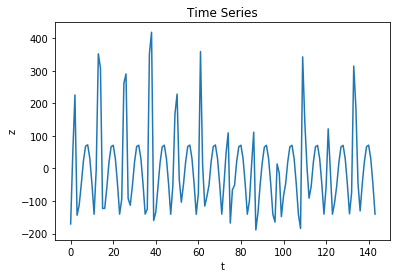

In [16]:
z = x
z[:,1] = x[:,1] - y_t
plt.plot(z[:,1])
plt.xlabel('t')
plt.ylabel('z')
plt.title('Time Series')

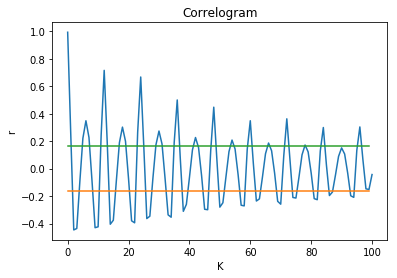

In [17]:
r = build_correlogram(z,k)
np.set_printoptions(precision=4)
#print(r)
lowerbound=[0-1.96/math.sqrt(x.shape[0])]*k
upperbound = [0+1.96/math.sqrt(x.shape[0])]*k
plt.plot(r)
plt.plot(lowerbound)
plt.plot(upperbound)
plt
plt.xlabel('K')
plt.ylabel('r')
plt.title('Correlogram')
plt.show()

Text(0.5,1,'Power Spectrum')

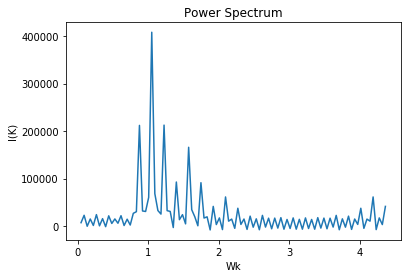

In [18]:
w,I = build_power_spectrum(z,k=100)
plt.plot(w,I)
plt.xlabel('Wk')
plt.ylabel('I(K)')
plt.title('Power Spectrum')

In [19]:
w_k = 0.5272603054975876
_=significance_test(I,w_k,z)

w_k 0.5272603054975876
periodicity 11.916666666666668
test_stat 0.020663740448698672
f(2,N-2) 3.059830688622633


In [20]:
i = np.argmax(I)
w_k = (2*math.pi*(i+1))/x.shape[0]
#w_k = 0.5272603054975876
y_t = significance_test(I,w_k,z)

w_k 1.0471975511965976
periodicity 6.0
test_stat 72.69548615100214
f(2,N-2) 3.059830688622633


Text(0.5,1,'Time Series')

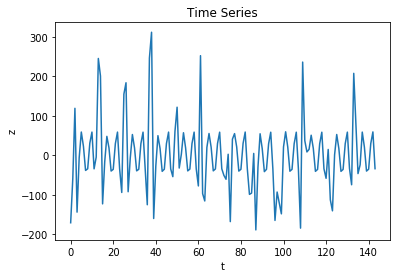

In [21]:
z[:,1] = z[:,1] - y_t
plt.plot(z[:,1])
plt.xlabel('t')
plt.ylabel('z')
plt.title('Time Series')

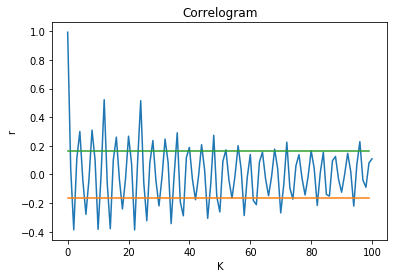

In [22]:
r = build_correlogram(z,k)
np.set_printoptions(precision=4)
#print(r)
lowerbound=[0-1.96/math.sqrt(x.shape[0])]*k
upperbound = [0+1.96/math.sqrt(x.shape[0])]*k
plt.plot(r)
plt.plot(lowerbound)
plt.plot(upperbound)
plt
plt.xlabel('K')
plt.ylabel('r')
plt.title('Correlogram')
plt.show()

Text(0.5,1,'Power Spectrum')

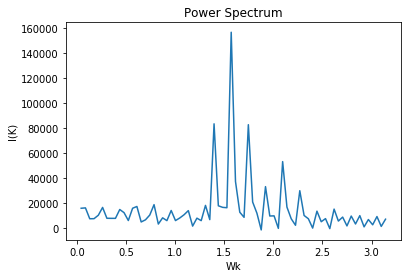

In [23]:
w,I = build_power_spectrum(z,k=72)
plt.plot(w,I)
plt.xlabel('Wk')
plt.ylabel('I(K)')
plt.title('Power Spectrum')

In [24]:
1.0545206109951752
_=significance_test(I,w_k,z)

w_k 1.0471975511965976
periodicity 6.0
test_stat 9.471911647464593e-30
f(2,N-2) 3.059830688622633


In [25]:
i = np.argmax(I)
w_k = (2*math.pi*(i+1))/x.shape[0]
#w_k = 0.5272603054975876
y_t = significance_test(I,w_k,z)

w_k 1.5707963267948966
periodicity 4.0
test_stat 44.76355983985568
f(2,N-2) 3.059830688622633


Text(0.5,1,'Time Series')

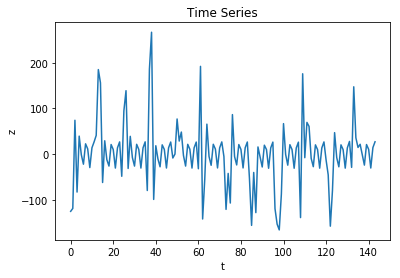

In [26]:
z[:,1] = z[:,1] - y_t
plt.plot(z[:,1])
plt.xlabel('t')
plt.ylabel('z')
plt.title('Time Series')

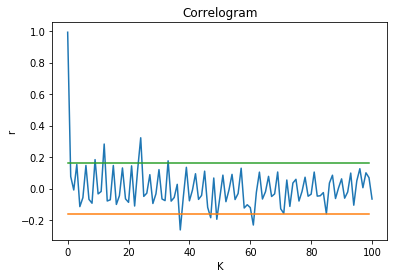

In [27]:
r = build_correlogram(z,k)
np.set_printoptions(precision=4)
#print(r)
lowerbound=[0-1.96/math.sqrt(x.shape[0])]*k
upperbound = [0+1.96/math.sqrt(x.shape[0])]*k
plt.plot(r)
plt.plot(lowerbound)
plt.plot(upperbound)
plt
plt.xlabel('K')
plt.ylabel('r')
plt.title('Correlogram')
plt.show()

Text(0.5,1,'Power Spectrum')

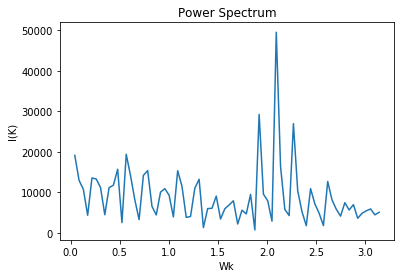

In [28]:
w,I = build_power_spectrum(z,k=72)
plt.plot(w,I)
plt.xlabel('Wk')
plt.ylabel('I(K)')
plt.title('Power Spectrum')

In [29]:
1.581780916492763
_=significance_test(I,w_k,z)

w_k 1.5707963267948966
periodicity 4.0
test_stat 3.366246299488823e-30
f(2,N-2) 3.059830688622633


In [30]:
def build_PAC(x,order):
    N = x.shape[0]
    x_t = x[:,1]
    x_hat = np.mean(x_t)
    #print('x_hat',x_hat)
    phi = np.zeros((order))
    for k in range(1,order+1):
        #print('k',k)
        corr_matrix = np.zeros((k+1,k+1))
        for i in range(k+1):
            #print('i',i)
            for j in range(k+1):
                #print('j',j)
                trunc_i = max(0,len(x_t[i:])-len(x_t[j:]))
                trunc_j = max(0,len(x_t[j:])-len(x_t[i:]))
                x_i = x_t[i:N-trunc_i]
                x_j = x_t[j:N-trunc_j]
                #print('x_',i,x_i)
                #print('x_',j,x_j)
                #print('x_i-x_hat',x_i-x_hat)
                #print('x_j-x_hat',x_j-x_hat)
                cov = (x_i-x_hat)*(x_j-x_hat)
                cov_sum = np.sum(cov)
                #print('cov',cov)
                #print('cov_sum',cov_sum)
                var_i = np.sum(np.square(x_i-x_hat),axis=0)
                #print('var_i',var_i)
                var_j = np.sum(np.square(x_j-x_hat),axis=0)
                #print('var_j',var_j)
                corr_matrix[i,j] = cov_sum/np.sqrt(var_i*var_j)
        #print('corr_matrix',corr_matrix)
        ro = corr_matrix[1:,0].reshape(k,1)
        #print('ro',ro)
        corr_matrix = corr_matrix[:-1,:-1]
        #print('corr_matrix',corr_matrix)
        corr_matrix_inv = np.linalg.pinv(corr_matrix)
        #print('np.dot(corr_matrix_inv,ro)',np.dot(corr_matrix_inv,ro))
        if k>0:
            phi[k-1] = np.dot(corr_matrix_inv,ro)[-1]
    #print('ro',ro)
    #print('corr_matrix',corr_matrix)
    return phi

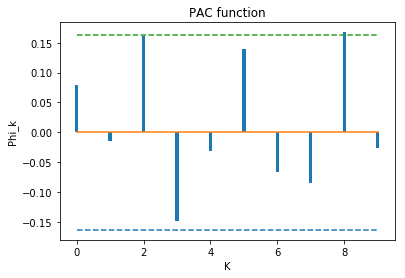

In [31]:
k = 10
N = x.shape[0]
phi = build_PAC(z,k)
zero_line = [0]*k
lowerbound=[0-1.96/math.sqrt(N)]*k
upperbound = [0+1.96/math.sqrt(N)]*k
plt.bar(np.arange(k),phi,width=0.1)
plt.plot(lowerbound,'--')
plt.plot(zero_line)
plt.plot(upperbound,'--')
plt
plt.xlabel('K')
plt.ylabel('Phi_k')
plt.title('PAC function')
plt.show()

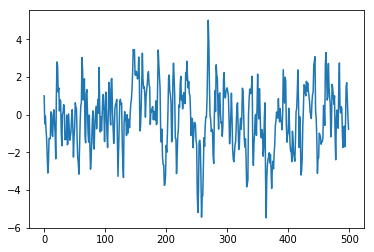

In [32]:
N = 500
x = np.zeros((N,2))
e = np.zeros(N)
x[:,0] = np.arange(1,N+1)
x[0,1] = np.random.randint(3,size=(1))
phi1 = 0.6
theta = 0.5
for i in range(1,N):
    e[i] = np.random.randn(1)
    x[i] = phi1*x[i-1,1] + theta*e[i-1] + e[i] #ARMA(1,1)
    #x[i] = theta*e[i-1] + e[i] #MA(1)
    #x[i] = phi1*x[i-1,1] + e[i] #AR(1)
plt.plot(x[:,1])

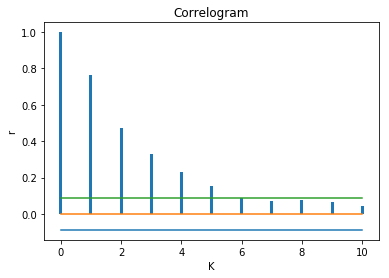

In [33]:
k = 10
r = build_correlogram(x,k)
np.set_printoptions(precision=4)
#print(r.shape)
lowerbound=[0-1.96/math.sqrt(x.shape[0])]*(k+1)
upperbound = [0+1.96/math.sqrt(x.shape[0])]*(k+1)
zero_line = [0]*(k+1)
plt.bar(np.arange(k+1),r,width=0.1)
plt.plot(lowerbound)
plt.plot(zero_line)
plt.plot(upperbound)
plt
plt.xlabel('K')
plt.ylabel('r')
plt.title('Correlogram')
plt.show()

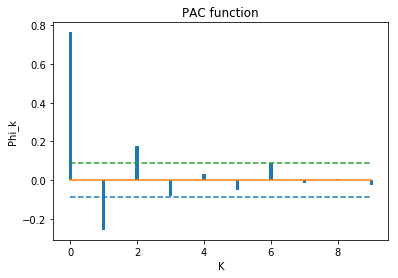

In [34]:
k = 10
#N = x.shape[0]
phi = build_PAC(x,k)
zero_line = [0]*k
lowerbound=[0-1.96/math.sqrt(N)]*k
upperbound = [0+1.96/math.sqrt(N)]*k
plt.bar(np.arange(k),phi,width=0.1)
plt.plot(lowerbound,'--')
plt.plot(zero_line)
plt.plot(upperbound,'--')
plt
plt.xlabel('K')
plt.ylabel('Phi_k')
plt.title('PAC function')
plt.show()

Residual (500,)
MSE 1.0164115145583992


<function matplotlib.pyplot.show>

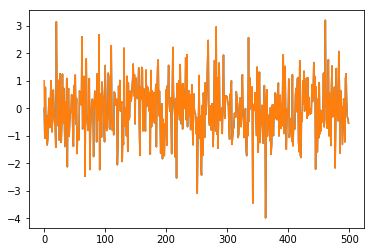

In [35]:
x_hat = np.zeros((N,1))
x_hat[1:,0] = phi1*x[:-1,1]+theta*e[:-1]
Residual = x[:,1] - x_hat[:,0]
print('Residual',Residual.shape)
MSE = (1/(N-1))*np.sum(np.square(Residual[1:]),axis=0)
print('MSE',MSE)
plt.plot(e)
plt.plot(Residual)
plt.show

In [36]:
residual_bar = np.mean(Residual,axis=0)
print('residual_bar',residual_bar)
residual_var = np.var(Residual,axis=0)
print('residual_var',residual_var)
test_stat = ((N**(1/2))*residual_bar)/np.sqrt(residual_var)
print('test_stat',test_stat)
print('t-twotail(0.05,N-1): ','[',-1*stats.t.ppf(1-0.025,N-1),',',stats.t.ppf(1-0.025,N-1),']')

residual_bar -0.047483092400020556
residual_var 1.0141240474654136
test_stat -1.0543345948895124
t-twotail(0.05,N-1):  [ -1.9647293909876649 , 1.9647293909876649 ]


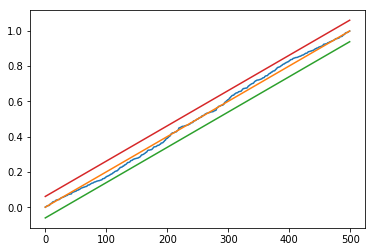

In [37]:
t = np.arange(1,N+1)
gamma_k_sqr = np.zeros(int(N))
for k in range(1,int((N)+1)):
    w_k = (2*math.pi*k)/N
    gamma_k_sqr[k-1] = np.square((2/N)*np.sum(Residual*np.cos(w_k*t),axis=0)) + np.square((2/N)*np.sum(Residual*np.sin(w_k*t),axis=0))

g_k = np.zeros(int(N))
for k in range(int(N)):
    g_k[k] = np.sum(gamma_k_sqr[:k],axis=0)/np.sum(gamma_k_sqr,axis=0)

lamb = 1.36
base_line = np.arange(int(N))/(N)
lower_bound = base_line - lamb/np.sqrt(N)
upper_bound = base_line + lamb/np.sqrt(N)
plt.plot(g_k)
plt.plot(base_line)
plt.plot(lower_bound)
plt.plot(upper_bound)

test_stat 0.6192734538521909
f(kmax,N-kmax) 1.3154782884428189


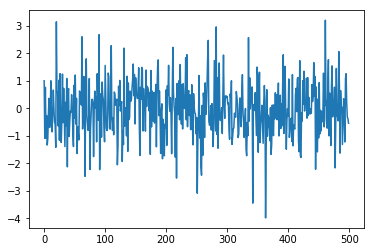

In [38]:
#Residual = np.array([0,1,2,3,4,5,6,7,8,9])
#print('Residual',Residual.shape)
#kmax = 3
#N = 10
plt.plot(Residual)
kmax = round(0.15*N)+1
cov_matrix = np.zeros((kmax,kmax))
for i in range(kmax):
    #print('i',i)
    for j in range(kmax):
        #print('j',j)
        k = np.abs(i-j)
        #print('k',k)
        e_j = Residual[k+1:]
        #print('e_j',e_j)
        e_jminusk = Residual[1:N-k]
        #print('e_jminusk',e_jminusk)
        cov_matrix[i,j] = (1/(N-k))*np.sum(e_j*e_jminusk,axis=0)
#cov_matrix = cov_matrix/cov_matrix[0,0]
#print('cov_matrix',cov_matrix)
#print('cov_matrix[:-1,:-1]',cov_matrix[:-1,:-1])
roh_0 = 1
roh_1 = np.linalg.det(cov_matrix)/np.linalg.det(cov_matrix[:-1,:-1])
#print(kmax-1)
test_stat = (N/(kmax-1))*((roh_0/roh_1)-1)
print('test_stat',test_stat)
print('f(kmax,N-kmax)',stats.f.ppf(q=1-0.05,dfn=kmax,dfd=N-kmax))